In [1]:
import sys
sys.path.append("../src")
from os.path import expanduser

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"
processed_data_path = main_path + "data/processed/"
trained_models = main_path + "scripts/notebooks/trained_models/"
combinations_dataframe_path = dataframes_path + "comp_df.csv"
sam_2_path = home+'/segment-anything-2'

In [3]:
sys.path.append(sam_2_path)
from sam2oracle import *
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
import pandas as pd

In [5]:
df_name = "lung_df"
train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [6]:
image_dim=128

In [7]:
sam2 = SAM2Oracle(img_size=(image_dim,image_dim))

In [14]:
import supervision as sv
import segmentation_models_pytorch as smp

In [15]:
def get_similarity(mask, gt_mask):
    if not torch.is_tensor(mask):
        mask = torch.tensor(mask)
    if not torch.is_tensor(gt_mask):
        gt_mask = torch.tensor(gt_mask)
        
    tp, fp, fn, tn = smp.metrics.get_stats(mask.long(), gt_mask.long(), mode="binary", threshold=0.5)
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return iou

In [16]:
ds=[]
for i in range(20):
    image = np.load(test_df["images"][i], allow_pickle=True)
    gt_mask = np.load(test_df["masks"][i], allow_pickle=True)
    masks = sam2.generateMasks(test_df["images"][i])
    for mask in masks:
        d = get_similarity(mask, gt_mask)
        ds.append(d)
        print(i,d)

0 tensor(0.)
0 tensor(0.8095)
0 tensor(0.)
1 tensor(0.)
2 tensor(0.0018)
2 tensor(0.)
2 tensor(0.8000)
2 tensor(0.)
2 tensor(0.)
2 tensor(0.0039)
3 tensor(0.)
3 tensor(0.)
3 tensor(0.6133)
3 tensor(0.)
3 tensor(0.)
4 tensor(0.0539)
4 tensor(0.)
4 tensor(0.)
4 tensor(0.)
4 tensor(0.)
4 tensor(0.1432)
4 tensor(0.)
5 tensor(0.0003)
5 tensor(0.)
5 tensor(0.0035)
5 tensor(0.)
5 tensor(0.0035)
5 tensor(0.)
5 tensor(0.)
5 tensor(0.)
5 tensor(0.)
6 tensor(0.)
6 tensor(0.)
6 tensor(0.)
6 tensor(0.)
6 tensor(0.)
7 tensor(0.)
7 tensor(0.)
7 tensor(0.)
7 tensor(0.)
7 tensor(0.0007)
7 tensor(0.)
7 tensor(0.)
7 tensor(0.)
8 tensor(0.9016)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
8 tensor(0.)
9 tensor(0.)
9 tensor(0.)
9 tensor(0.)
9 tensor(0.)
9 tensor(0.)
10 tensor(0.)
10 tensor(0.0504)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
10 tensor(0.)
11 tensor(0.0229)
11 tensor(0.0031)
11 te

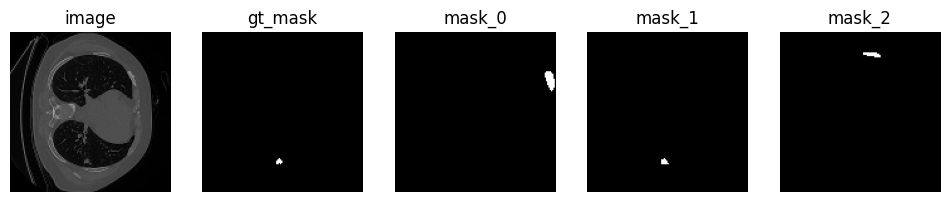

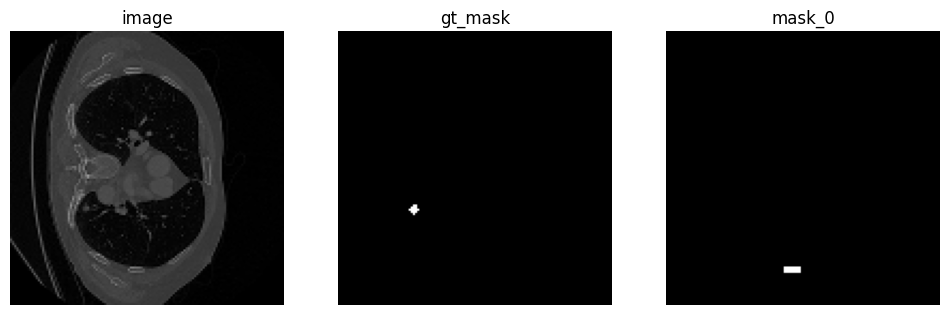

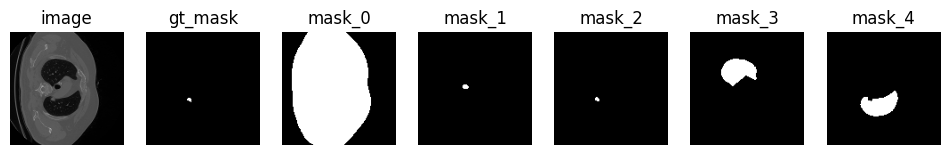

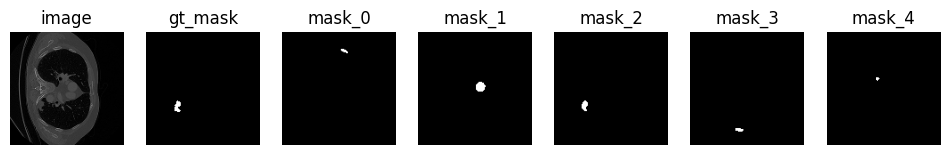

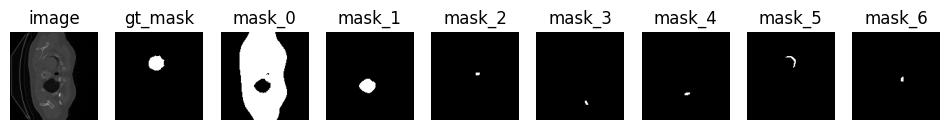

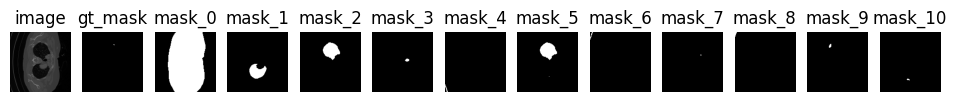

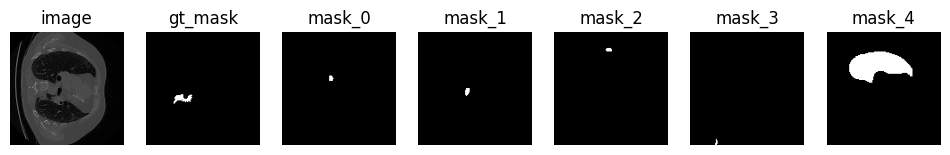

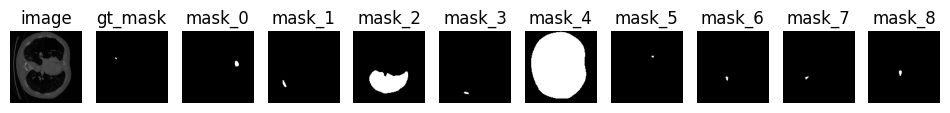

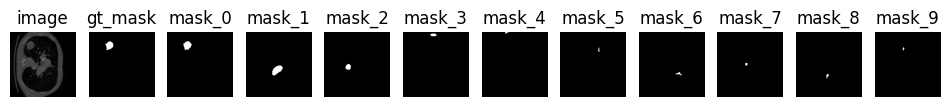

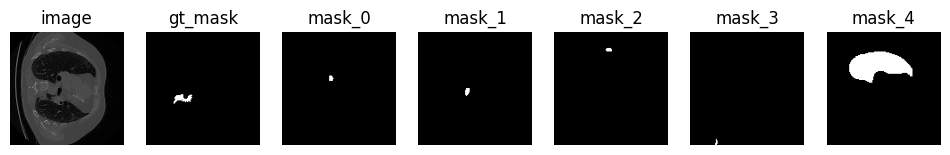

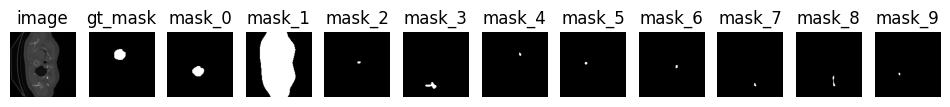

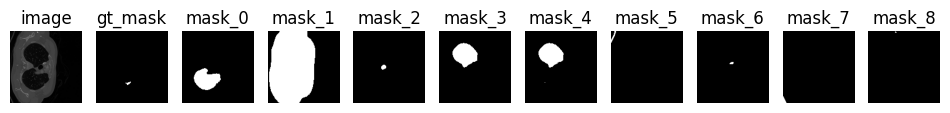

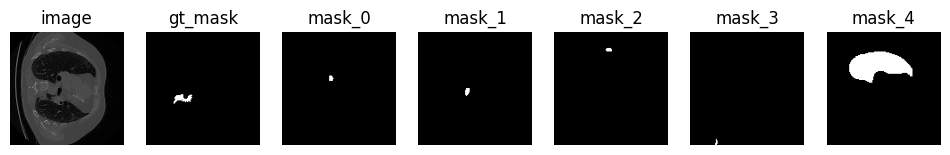

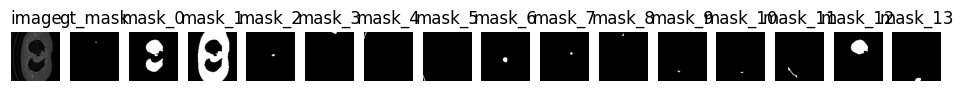

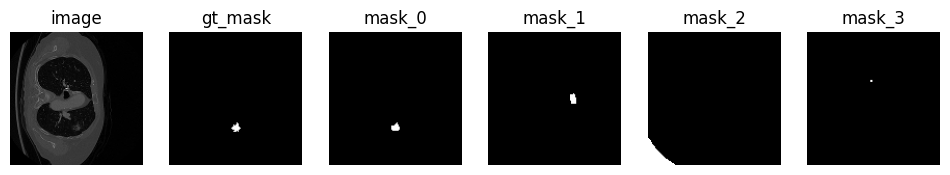

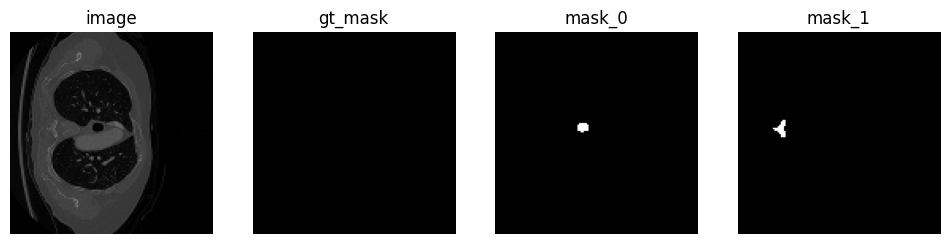

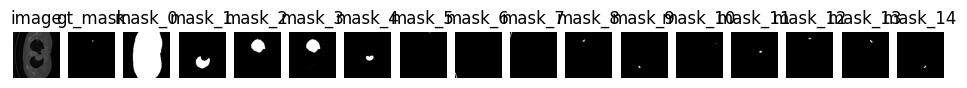

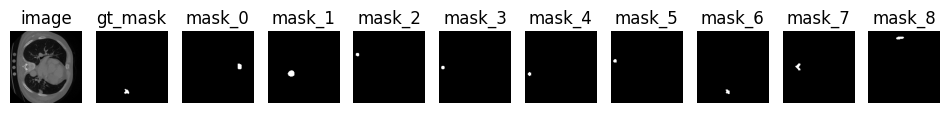

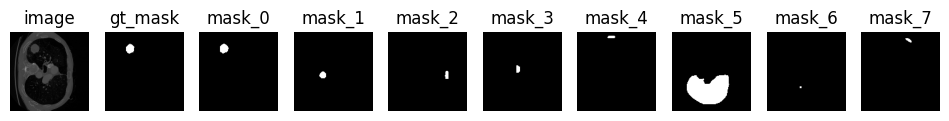

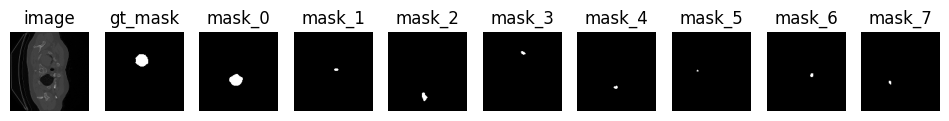

In [11]:
gt_masks=[]
images=[]
for i in range(20):
    images.append(np.load(test_df["images"][i], allow_pickle=True))
    gt_masks.append(np.load(test_df["masks"][i], allow_pickle=True))
    masks = sam2.generateMasks(test_df["images"][i])
    if len(masks)>0:
        sv.plot_images_grid(
            images=[images[i], gt_masks[i]]+masks,
            grid_size=(1,len(masks)+2),
            titles=["image", "gt_mask"]+[f"mask_{i}" for i in range(len(masks))]
        )
    else:
        print("No generated masks for item : ", i)